In [ ]:
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer

In [2]:
from datasets import load_dataset
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import matplotlib.pyplot as plt
from transformers import WhisperTokenizer, WhisperFeatureExtractor, WhisperForConditionalGeneration
import torch

# Preprocess sample rate

In [3]:
atco_asr_data = load_dataset("jlvdoorn/atco2-asr-atcosim", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/942 [00:00<?, ?B/s]

(…)-00000-of-00005-c6681348ac8543dc.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

(…)-00001-of-00005-464e7b29cac82caf.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

(…)-00002-of-00005-008f85162351773d.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

(…)-00003-of-00005-13846616069619e5.parquet:   0%|          | 0.00/387M [00:00<?, ?B/s]

(…)-00004-of-00005-0565e63298f50d49.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

(…)-00000-of-00002-7a5ea3756991bf72.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

(…)-00001-of-00002-56cef56513136770.parquet:   0%|          | 0.00/245M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8092 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2026 [00:00<?, ? examples/s]

In [4]:
atco_asr_data[0]

{'audio': {'path': 'LKPR_RUZYNE_Radar_120_520MHz_20201025_091112.wav',
  'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.10351562e-05, -6.10351562e-05, -6.10351562e-05]),
  'sampling_rate': 16000},
 'text': 'Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo ',
 'info': 'LKPR\nPraha Ruzyne\nRadar\nAKEVA ARVEG BAGRU BAROX BAVIN BEKVI ELMEK ELPON ERASU EVEMI KENOK KUVIX LETNA RATEV RISUK SOMIS SULOV TIPRU UTORO\nBLA131 BLA1XQ BTI7PY CTN480 DLH3NL DLH9TP ETD72E EWG6HP FIN1DH IRA711 KLM44K MLD863 MLD864 OKHBT OKLLZ OKMHZ OKPHM OKWUS17 OKYAI14 RYR1JU RYR4945 SXS7D THY32B THY6577 TIE790J UAE73  \nAll Charter Air Baltic Croatia Lufthansa Etihad Eurowings Finn Iranair Klm Moldova Oklahoma Okapi Alfa Ryan Sunexpress Turkish Time Emirates'}

In [5]:
audio_original = atco_asr_data[0]['audio']['array']
original_sample_rate = atco_asr_data[0]['audio']['sampling_rate']
print(audio_original.shape, original_sample_rate)

(117760,) 16000


In [6]:
# Play the audio
Audio(audio_original, rate=original_sample_rate)

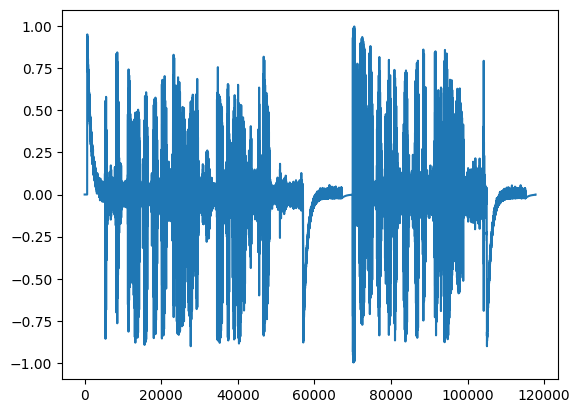

In [7]:
plt.plot(audio_original)

In [8]:
target_sample_rate = 16000

# Calculate the len of sample for the target sample rate
len_sample = int(len(audio_original) * target_sample_rate / original_sample_rate)

# Resample the audio to the target sample rate
downsampled_audio = resample(audio_original, len_sample)

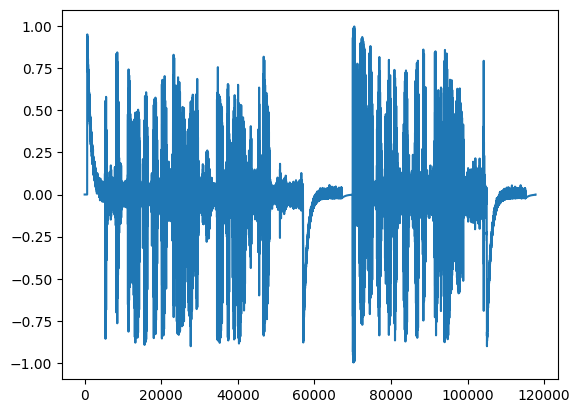

In [9]:
plt.plot(downsampled_audio)

# Format target text for training

In [10]:
target = atco_asr_data[0]['text']
target

'Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo '

In [11]:
# Transform text to token
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language='english', task='transcribe')

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [12]:
tokenizer_output = tokenizer(target, padding='max_length', max_length=448, truncation=True, return_tensors='pt')

encoded_target = tokenizer_output['input_ids']
attention_mask = tokenizer_output['attention_mask']

encoded_target.shape, attention_mask.shape

(torch.Size([1, 448]), torch.Size([1, 448]))

In [13]:
tokenizer.decode(encoded_target[0])

'<|startoftranscript|><|en|><|transcribe|><|notimestamps|>Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end

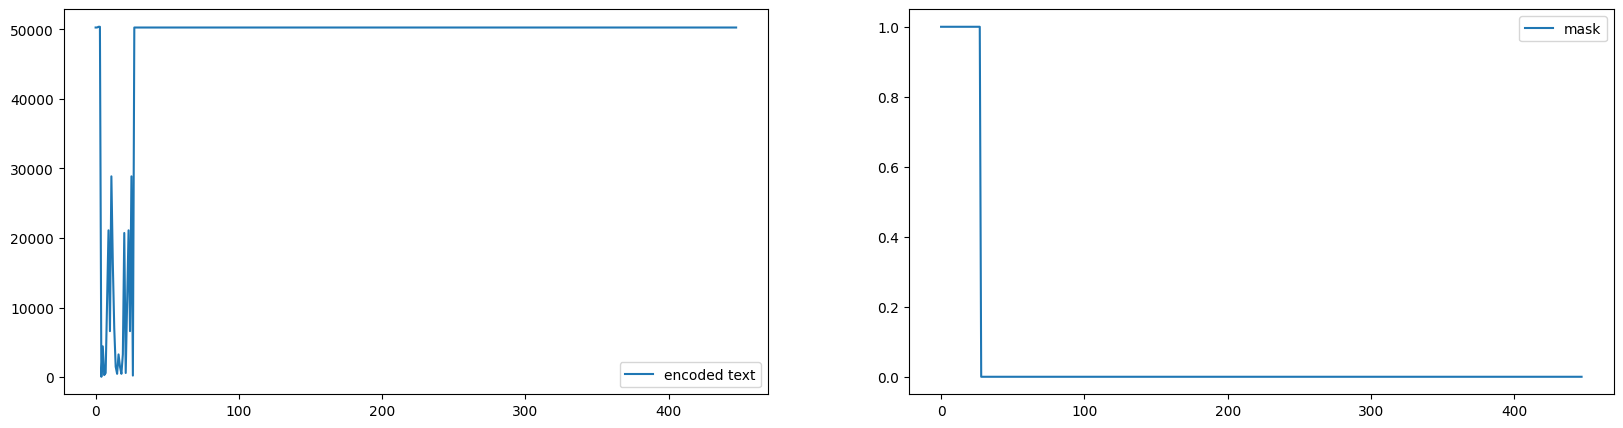

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1) #subplot-left
plt.plot(encoded_target.reshape(-1,1), label='encoded text')  # [1,148] -> [148,1]
plt.legend()  # Show label
plt.subplot(1,2,2) #subplot-right
plt.plot(attention_mask.reshape(-1,1), label='mask')
plt.legend()  # Show label
plt.show()

In [15]:
# Replace all elements in encoded_target by -100 by position of elements value 0 (not 1) in attention_mask
encoded_target = encoded_target.masked_fill(attention_mask.ne(1),-100)

In [16]:
encoded_target

tensor([[50258, 50259, 50359, 50363,    46,  4417,   289,   591, 10720, 21102,
          6602, 28861, 16333,  7018,  1496,   472,  3262,  1496,   472,  3262,
         20718,   591, 10720, 21102,  6602, 28861,   220, 50257,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  

In [17]:
tokenizer.decode(encoded_target[0])

'<|startoftranscript|><|en|><|transcribe|><|notimestamps|>Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo <|endoftext|>'

# The input feature to the model

In [18]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small", language='english', task='transcribe')

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [19]:
# Return features from input audio for train whisper
input_feature = feature_extractor(raw_speech=downsampled_audio,
                                  sampling_rate=16000,
                                  return_tensors='pt').input_features

input_feature

tensor([[[-0.4279, -0.4279, -0.4279,  ..., -0.4279, -0.4279, -0.4279],
         [-0.4279, -0.4279, -0.4279,  ..., -0.4279, -0.4279, -0.4279],
         [-0.4279, -0.4279, -0.4279,  ..., -0.4279, -0.4279, -0.4279],
         ...,
         [-0.4279, -0.4279, -0.4279,  ..., -0.4279, -0.4279, -0.4279],
         [-0.4279, -0.4279, -0.4279,  ..., -0.4279, -0.4279, -0.4279],
         [-0.4279, -0.4279, -0.4279,  ..., -0.4279, -0.4279, -0.4279]]])

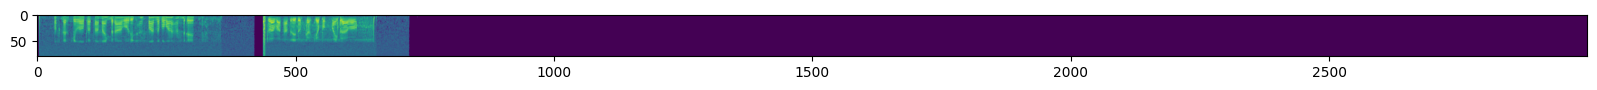

In [20]:
plt.figure(figsize=(20,20)) # Create figure with size
plt.imshow(input_feature.squeeze()) # .squeeze(): [1, 80, N] -> [1, 80]
plt.show()

# Prediction using Whisper Model

In [21]:
# Use cuda() for using GPU to run model
# model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [22]:
with torch.no_grad(): # turn off gradient calculation
  # Prediction by input_features, output by token IDs
  # op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')
  op = model.generate(input_feature, language='english', task='transcribe')

# Transform tokenIDs to text
tokenizer.batch_decode(op, skip_special_tokens=False)

with torch.no_grad():
  # Calculate loss with encoded_target
  # op = model(input_feature.to('cuda'), labels=encoded_target)
  op = model(input_feature, labels=encoded_target)

print(op.loss)
print(op.logits.shape)

# Compute Probabilities from Logits and Find the Most Likely Token
activations = torch.nn.functional.softmax(op.logits, dim=-1)
pred_token_ids = torch.argmax(activations, dim=-1)

print(activations.shape, pred_token_ids.shape)

print(tokenizer.batch_decode(pred_token_ids, skip_special_tokens=False))

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


tensor(3.8588)
torch.Size([1, 448, 51865])
torch.Size([1, 448, 51865]) torch.Size([1, 448])
['<|cs|><|translate|><|transcribe|><|notimestamps|> Oscarscar,ilo, Mike Bravo, to level 100 hundred<|endoftext|> one hundred O Kilo Papa Mike Bravo<|endoftext|>!!!!<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e

# Performance before finetuning

In [23]:
for index in range(10):
  target = atco_asr_data[index]['text']
  audio_original = atco_asr_data[index]['audio']['array']

  input_feature = feature_extractor(raw_speech=audio_original,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

  with torch.no_grad():
    # op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')
    op = model.generate(input_feature, language='english', task='transcribe')

  text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

  print(f'--------{index}--------')
  print(f'true: {target} \npred: {text_pred}')
  print('\n')

--------0--------
true: Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo  
pred:  Oscar Quilopapa Mike Bravo, RISC100


--------1--------
true: Oscar Kilo Kilo Echo Alfa Praha Radar identified climb flight level one hundred IFR flight starts  now time zero five cleared to destination via flight plan route  
pred:  Oscar kilo kilo, Eqa, Praha radar identified. Consulate level 100, AFL, now time 05, quick destination, WFL, BenRoot.


--------2--------
true: Ryanair Seven Three Alpha Hotel turn left heading three six zero Ryanair Seven Three Alpha Hotel  
pred:  Ryanair 730 hotel on left heading 360 Ryanair 730 hotel


--------3--------
true: Oscar Kilo Kilo Uniform November proceed direct Baltu proceed direct Baltu Oscar Kilo Kilo Uniform November  
pred:  Oscar, what did you say in the phone number?


--------4--------
true: Oscar Mike Papa turn right heading zero two zero cleared ILS approach runway zero six speed maximum one six 